In [22]:
# -*- coding: utf-8 -*-
"""Untitled0.ipynb

Automatically generated by Colab.

Original file is located at
    https://colab.research.google.com/drive/1AEDveXbgMgParphP4bz-9GethI7Y1_ED
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from statsmodels.stats.weightstats import DescrStatsW
import requests
from io import BytesIO
from zipfile import ZipFile

# URL del archivo zip
url = "https://www.indec.gob.ar/ftp/cuadros/menusuperior/engho/engho2018_hogares.zip"

# Descargar el contenido del archivo zip
response = requests.get(url)
zip_file = ZipFile(BytesIO(response.content))

# Obtener la lista de archivos en el zip para encontrar el archivo .txt
files = zip_file.namelist()

# Encontrar el nombre del archivo .txt
txt_file_name = [file for file in files if file.endswith('.txt')][0]

def filtro1(data, i, region=False):
    n = data.shape[0]
    if region:
        n_data = data[data['region'] == i]
    else:
        n_data = data[data['provincia'] == i]
    fn_data = n_data.drop(['region', 'provincia', 'id', 'hacina', 'jcomed', 'gastotpc', 'gastot', 'ingtoth'], axis=1)

    # Gasto bajo es un gasto por debajo de la media de la suma de los primeros 3 grupos de gasto
    g3 = (fn_data['gc09_01'] + fn_data['gc09_02'] + fn_data['gc09_03']).mean()
    g6 = (fn_data['gc09_01'] + fn_data['gc09_02'] + fn_data['gc09_03'] + fn_data['gc09_04'] + fn_data['gc09_05'] + fn_data['gc09_06']).mean()
    g9 = (fn_data['gc09_01'] + fn_data['gc09_02'] + fn_data['gc09_03'] + fn_data['gc09_04'] + fn_data['gc09_05'] + fn_data['gc09_06'] + fn_data['gc09_07'] + fn_data['gc09_08'] + fn_data['gc09_09']).mean()
    gasto = []
    l = np.array(fn_data[['gc09_01', 'gc09_02', 'gc09_03', 'gc09_04', 'gc09_05', 'gc09_06', 'gc09_07', 'gc09_08', 'gc09_09']].values.tolist())
    for i in range(l.shape[0]):
        gasto.append(int(l[i][0:2].sum() > g3) + int(l[i][0:5].sum() > g6) + int(l[i][0:8].sum() > g9))
    fn_data['gasto'] = gasto

    #ingch
    #fn_data['ingpch'] = pow(fn_data['ingpch'],2)
    #fn_data['ingpch'] = pow(fn_data['ingpch'],3)

    # propauto
    fn_data['propauto'] = fn_data['propauto'].apply(lambda x: 1 if x in [2, 3] else 0)

    # regten regimen de tenencia
    fn_data['regten'] = fn_data['regten'].apply(lambda x: 1 if x == 1 else 0)

    # jniveled
    fn_data['prim'] = fn_data['jniveled'].apply(lambda x: 1 if x in [2, 3] else 0)
    fn_data['sec'] = fn_data['jniveled'].apply(lambda x: 1 if x in [4, 5] else 0)
    fn_data['univ'] = fn_data['jniveled'].apply(lambda x: 1 if x == 6 else 0)
    fn_data = fn_data.drop(['jniveled'], axis=1)

    fn_data['edad_25/34'] = fn_data['jedad_agrup'].apply(lambda x: 1 if x == 3 else 0)
    fn_data['edad_35/49'] = fn_data['jedad_agrup'].apply(lambda x: 1 if x in [4, 5] else 0)
    fn_data['edad65_mas'] = fn_data['jedad_agrup'].apply(lambda x: 1 if x == 6 else 0)
    fn_data = fn_data.drop(['jedad_agrup'], axis=1)

    fn_data['casado'] = fn_data['jsitconyugal'].apply(lambda x: 1 if x in [1, 2] else 0)

    fn_data['jestado'] = fn_data['jestado'].apply(lambda x: 1 if x == 1 else 0)

    fn_data['asalariado'] = fn_data['jocupengh'].apply(lambda x: 1 if x == 1 else 0)
    fn_data['propia_soc_jur'] = fn_data['jocupengh'].apply(lambda x: 1 if x == 2 else 0)
    fn_data['propia_soc_no_jur'] = fn_data['jocupengh'].apply(lambda x: 1 if x == 3 else 0)
    fn_data['socio_soc_jur'] = fn_data['jocupengh'].apply(lambda x: 1 if x == 4 else 0)
    fn_data['socio_soc_no_jur'] = fn_data['jocupengh'].apply(lambda x: 1 if x == 5 else 0)
    fn_data = fn_data.drop(['jocupengh'], axis=1)

    fn_data['jpercept'] = fn_data['jpercept'] - 1

    fn_data['clima_educativo'] = fn_data['clima_educativo'].apply(lambda x: 0 if x == 99 else x)
    fn_data['clima_educativo'] = fn_data['clima_educativo'].apply(lambda x: round(fn_data['clima_educativo'].mean()) if x == 0 else x)
    return fn_data

def plot_histograma_gasto(df):
    plt.figure(figsize=(10, 6))
    plt.hist(np.log(df['gasto'][df['gasto'] > 0]), bins=30, color='skyblue', edgecolor='black')
    plt.title('Histograma del Gasto (Log)')
    plt.xlabel('Log del Gasto')
    plt.ylabel('Frecuencia')
    plt.grid(True)
    plt.show()

def plot_histograma_ingpch(df):
    plt.figure(figsize=(10, 6))
    plt.hist(np.log(df['ingpch'][df['ingpch'] > 0]), bins=30, color='lightgreen', edgecolor='black')
    plt.title('Histograma del Ingreso per Cápita (Log)')
    plt.xlabel('Log del Ingreso per Cápita')
    plt.ylabel('Frecuencia')
    plt.grid(True)
    plt.show()

"""
def plot_heatmap(df):
    plt.figure(figsize=(14, 10))
    # Seleccionar solo las columnas numéricas
    numeric_df = df.select_dtypes(include=[np.number])
    corr = numeric_df.corr()
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Heatmap de Correlación de Variables')
    plt.show()
"""


def plot_bar_gasto_educacion(df):
    gasto_promedio_educacion = df.groupby(['prim', 'sec', 'univ'])['gasto'].mean().reset_index()
    gasto_promedio_educacion['Educación'] = gasto_promedio_educacion.apply(
        lambda row: 'Primaria' if row['prim'] == 1 else ('Secundaria' if row['sec'] == 1 else 'Universitaria'),
        axis=1
    )
    plt.figure(figsize=(10, 6))
    plt.bar(gasto_promedio_educacion['Educación'], gasto_promedio_educacion['gasto'], color=['skyblue', 'lightgreen', 'salmon'])
    plt.title('Promedio de Gasto por Nivel de Educación')
    plt.xlabel('Nivel de Educación')
    plt.ylabel('Gasto Promedio')
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    with zip_file.open(txt_file_name) as file:
        data = pd.read_csv(file, delimiter='|')
        data[0] = ('ingpch2')
    fdata_nea = filtro1(data, 4, region=True)
    n = fdata_nea.shape[0]
    fdata_nea['ingpch'] = fdata_nea['ingpch'].apply(lambda x: np.log(x) if x > 0 else 0)



    X_2 = pow(fdata_nea['ingpch2'],2)
    X_2 = sm.add_constant(X_2)
    y = fdata_nea[['gasto']]
    reg3 = sm.OLS(y,X_2).fit()

    print(reg3.summary())

    X = fdata_nea['ingpch']
    X = sm.add_constant(X)
    y = fdata_nea[['gasto']]
    reg1 = sm.OLS(y, X).fit()
    print(reg1.summary())

    X = fdata_nea[['ingpch','ingpch2', 'clima_educativo', 'asalariado', 'propia_soc_jur', 'propia_soc_no_jur', 'socio_soc_jur', 'socio_soc_no_jur', 'jestado', 'casado', 'univ', 'sec', 'prim', 'regten', 'propauto', 'cantmiem', 'edad_25/34', 'edad_35/49', 'edad65_mas']]
    X = sm.add_constant(X)
    y = fdata_nea[['gasto']]
    reg2 = sm.OLS(y, X).fit()
    print(reg2.summary())

    #plot_heatmap(fdata_nea)
    plot_histograma_gasto(fdata_nea)
    plot_histograma_ingpch(fdata_nea)
    plot_bar_gasto_educacion(fdata_nea)

KeyError: 'ingpch2'

                            OLS Regression Results                            
Dep. Variable:                  gasto   R-squared:                       0.046
Model:                            OLS   Adj. R-squared:                  0.046
Method:                 Least Squares   F-statistic:                     130.4
Date:                Tue, 23 Jul 2024   Prob (F-statistic):           1.60e-29
Time:                        20:36:08   Log-Likelihood:                -4255.1
No. Observations:                2714   AIC:                             8514.
Df Residuals:                    2712   BIC:                             8526.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.6344      0.130     -4.892      0.0

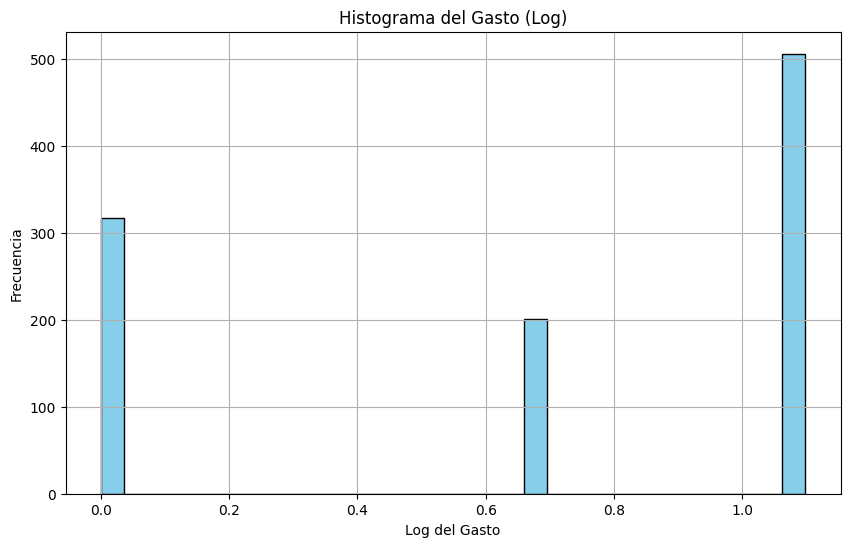

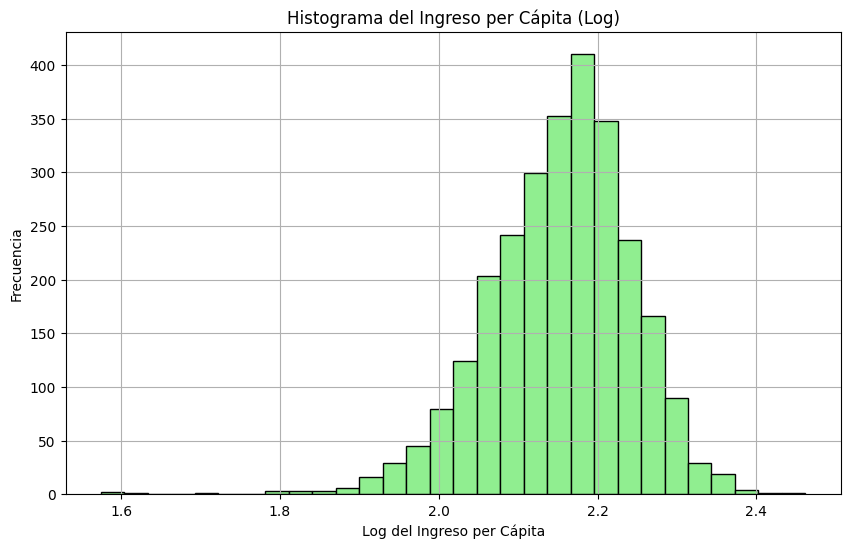

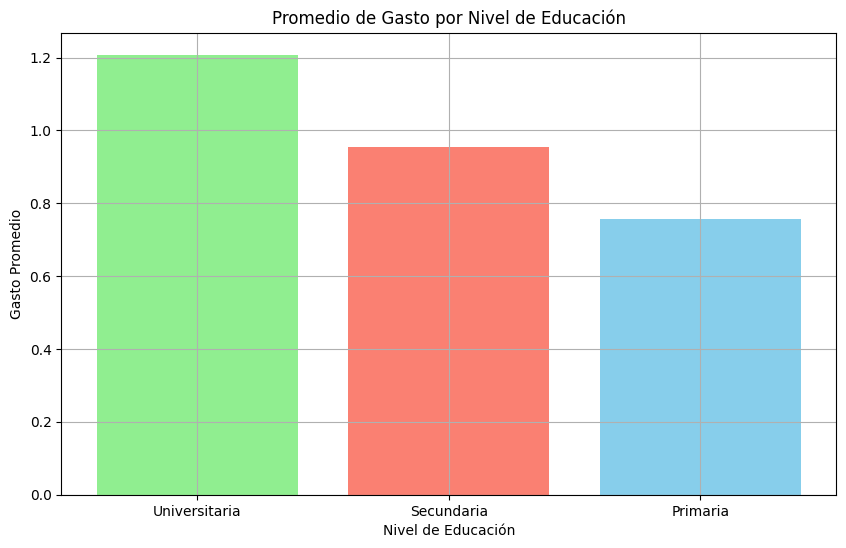

In [98]:
# -*- coding: utf-8 -*-
"""Untitled0.ipynb

Automatically generated by Colab.

Original file is located at
    https://colab.research.google.com/drive/1AEDveXbgMgParphP4bz-9GethI7Y1_ED
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from statsmodels.stats.weightstats import DescrStatsW
import requests
from io import BytesIO
from zipfile import ZipFile

# URL del archivo zip
url = "https://www.indec.gob.ar/ftp/cuadros/menusuperior/engho/engho2018_hogares.zip"

# Descargar el contenido del archivo zip
response = requests.get(url)
zip_file = ZipFile(BytesIO(response.content))

# Obtener la lista de archivos en el zip para encontrar el archivo .txt
files = zip_file.namelist()

# Encontrar el nombre del archivo .txt
txt_file_name = [file for file in files if file.endswith('.txt')][0]

def filtro1(data, i, region=False):
    n = data.shape[0]
    if region:
        n_data = data[data['region'] == i]
    else:
        n_data = data[data['provincia'] == i]
    fn_data = n_data.drop(['region', 'provincia', 'id', 'hacina', 'jcomed', 'gastotpc', 'gastot', 'ingtoth'], axis=1)

    # Gasto bajo es un gasto por debajo de la media de la suma de los primeros 3 grupos de gasto
    g3 = (fn_data['gc09_01'] + fn_data['gc09_02'] + fn_data['gc09_03']).mean()
    g6 = (fn_data['gc09_01'] + fn_data['gc09_02'] + fn_data['gc09_03'] + fn_data['gc09_04'] + fn_data['gc09_05'] + fn_data['gc09_06']).mean()
    g9 = (fn_data['gc09_01'] + fn_data['gc09_02'] + fn_data['gc09_03'] + fn_data['gc09_04'] + fn_data['gc09_05'] + fn_data['gc09_06'] + fn_data['gc09_07'] + fn_data['gc09_08'] + fn_data['gc09_09']).mean()
    gasto = []
    l = np.array(fn_data[['gc09_01', 'gc09_02', 'gc09_03', 'gc09_04', 'gc09_05', 'gc09_06', 'gc09_07', 'gc09_08', 'gc09_09']].values.tolist())
    for i in range(l.shape[0]):
        gasto.append(int(l[i][0:2].sum() > g3) + int(l[i][0:5].sum() > g6) + int(l[i][0:8].sum() > g9))
    fn_data['gasto'] = gasto

    data['ingpch2'] = data['ingpch'].copy()
    #data = data.rename(columns={'ingpch2':'ingpch2'})


    #ingch
    fn_data['ingpch2'] = pow(fn_data['ingpch2'],2)
    fn_data['ingpch3'] = pow(fn_data['ingpch3'],3)

    # propauto
    fn_data['propauto'] = fn_data['propauto'].apply(lambda x: 1 if x in [2, 3] else 0)

    # regten regimen de tenencia
    fn_data['regten'] = fn_data['regten'].apply(lambda x: 1 if x == 1 else 0)

    # jniveled
    fn_data['prim'] = fn_data['jniveled'].apply(lambda x: 1 if x in [2, 3] else 0)
    fn_data['sec'] = fn_data['jniveled'].apply(lambda x: 1 if x in [4, 5] else 0)
    fn_data['univ'] = fn_data['jniveled'].apply(lambda x: 1 if x == 6 else 0)
    fn_data = fn_data.drop(['jniveled'], axis=1)

    fn_data['edad_25/34'] = fn_data['jedad_agrup'].apply(lambda x: 1 if x == 3 else 0)
    fn_data['edad_35/49'] = fn_data['jedad_agrup'].apply(lambda x: 1 if x in [4, 5] else 0)
    fn_data['edad65_mas'] = fn_data['jedad_agrup'].apply(lambda x: 1 if x == 6 else 0)
    fn_data = fn_data.drop(['jedad_agrup'], axis=1)

    fn_data['casado'] = fn_data['jsitconyugal'].apply(lambda x: 1 if x in [1, 2] else 0)

    fn_data['jestado'] = fn_data['jestado'].apply(lambda x: 1 if x == 1 else 0)

    fn_data['asalariado'] = fn_data['jocupengh'].apply(lambda x: 1 if x == 1 else 0)
    fn_data['propia_soc_jur'] = fn_data['jocupengh'].apply(lambda x: 1 if x == 2 else 0)
    fn_data['propia_soc_no_jur'] = fn_data['jocupengh'].apply(lambda x: 1 if x == 3 else 0)
    fn_data['socio_soc_jur'] = fn_data['jocupengh'].apply(lambda x: 1 if x == 4 else 0)
    fn_data['socio_soc_no_jur'] = fn_data['jocupengh'].apply(lambda x: 1 if x == 5 else 0)
    fn_data = fn_data.drop(['jocupengh'], axis=1)

    fn_data['jpercept'] = fn_data['jpercept'] - 1

    fn_data['clima_educativo'] = fn_data['clima_educativo'].apply(lambda x: 0 if x == 99 else x)
    fn_data['clima_educativo'] = fn_data['clima_educativo'].apply(lambda x: round(fn_data['clima_educativo'].mean()) if x == 0 else x)
    return fn_data

def plot_histograma_gasto(df):
    plt.figure(figsize=(10, 6))
    plt.hist(np.log(df['gasto'][df['gasto'] > 0]), bins=30, color='skyblue', edgecolor='black')
    plt.title('Histograma del Gasto (Log)')
    plt.xlabel('Log del Gasto')
    plt.ylabel('Frecuencia')
    plt.grid(True)
    plt.show()

def plot_histograma_ingpch(df):
    plt.figure(figsize=(10, 6))
    plt.hist(np.log(df['ingpch'][df['ingpch'] > 0]), bins=30, color='lightgreen', edgecolor='black')
    plt.title('Histograma del Ingreso per Cápita (Log)')
    plt.xlabel('Log del Ingreso per Cápita')
    plt.ylabel('Frecuencia')
    plt.grid(True)
    plt.show()

"""
def plot_heatmap(df):
    plt.figure(figsize=(14, 10))
    # Seleccionar solo las columnas numéricas
    numeric_df = df.select_dtypes(include=[np.number])
    corr = numeric_df.corr()
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Heatmap de Correlación de Variables')
    plt.show()
"""


def plot_bar_gasto_educacion(df):
    gasto_promedio_educacion = df.groupby(['prim', 'sec', 'univ'])['gasto'].mean().reset_index()
    gasto_promedio_educacion['Educación'] = gasto_promedio_educacion.apply(
        lambda row: 'Primaria' if row['prim'] == 1 else ('Secundaria' if row['sec'] == 1 else 'Universitaria'),
        axis=1
    )
    plt.figure(figsize=(10, 6))
    plt.bar(gasto_promedio_educacion['Educación'], gasto_promedio_educacion['gasto'], color=['skyblue', 'lightgreen', 'salmon'])
    plt.title('Promedio de Gasto por Nivel de Educación')
    plt.xlabel('Nivel de Educación')
    plt.ylabel('Gasto Promedio')
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    with zip_file.open(txt_file_name) as file:
        data = pd.read_csv(file, delimiter='|')

        #Agregamos una copia de la columna que muestre el resultado en potencia de 2
        data['ingpch2'] = data['ingpch'].copy()
        data = data.rename(columns={'ingpch2':'ingpch2'})

        #Agregamos una copia de la columna que muestre el resultado en cubico
        data['ingpch3'] = data['ingpch'].copy()
        data = data.rename(columns={'ingpch3':'ingpch3'})

    fdata_nea = filtro1(data, 4, region=True)
    n = fdata_nea.shape[0]
    fdata_nea['ingpch'] = fdata_nea['ingpch'].apply(lambda x: np.log(x) if x > 0 else 0)


    print(reg3.summary())
    X = fdata_nea['ingpch']
    X = sm.add_constant(X)
    y = fdata_nea[['gasto']]
    reg1 = sm.OLS(y, X).fit()
    print(reg1.summary())

    X = fdata_nea[['ingpch2','ingpch3','clima_educativo', 'asalariado', 'propia_soc_jur', 'propia_soc_no_jur', 'socio_soc_jur', 'socio_soc_no_jur', 'jestado', 'casado', 'univ', 'sec', 'prim', 'regten', 'propauto', 'cantmiem', 'edad_25/34', 'edad_35/49', 'edad65_mas']]
    X = sm.add_constant(X)
    y = fdata_nea[['gasto']]
    reg2 = sm.OLS(y, X).fit()
    print(reg2.summary())

    #plot_heatmap(fdata_nea)
    plot_histograma_gasto(fdata_nea)
    plot_histograma_ingpch(fdata_nea)
    plot_bar_gasto_educacion(fdata_nea)